In [1]:
pip install optuna



  Obtaining dependency information for optuna from https://files.pythonhosted.org/packages/28/09/c4d329f7969443cdd4d482048ca406b6f61cda3c8e99ace71feaec7c8734/optuna-4.2.1-py3-none-any.whl.metadata
  Obtaining dependency information for alembic>=1.5.0 from https://files.pythonhosted.org/packages/99/f7/d398fae160568472ddce0b3fde9c4581afc593019a6adc91006a66406991/alembic-1.15.1-py3-none-any.whl.metadata
  Obtaining dependency information for colorlog from https://files.pythonhosted.org/packages/e3/51/9b208e85196941db2f0654ad0357ca6388ab3ed67efdbfc799f35d1f83aa/colorlog-6.9.0-py3-none-any.whl.metadata
  Obtaining dependency information for Mako from https://files.pythonhosted.org/packages/cd/83/de0a49e7de540513f53ab5d2e105321dedeb08a8f5850f0208decf4390ec/Mako-1.3.9-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/383.6 kB ? eta -:--:--
   ------------------- -------------------- 184.3/383.6 kB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 383.6/

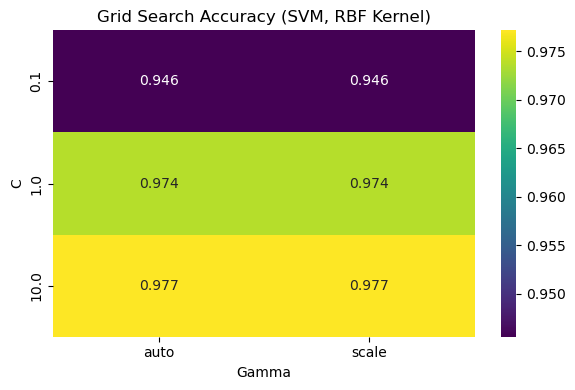

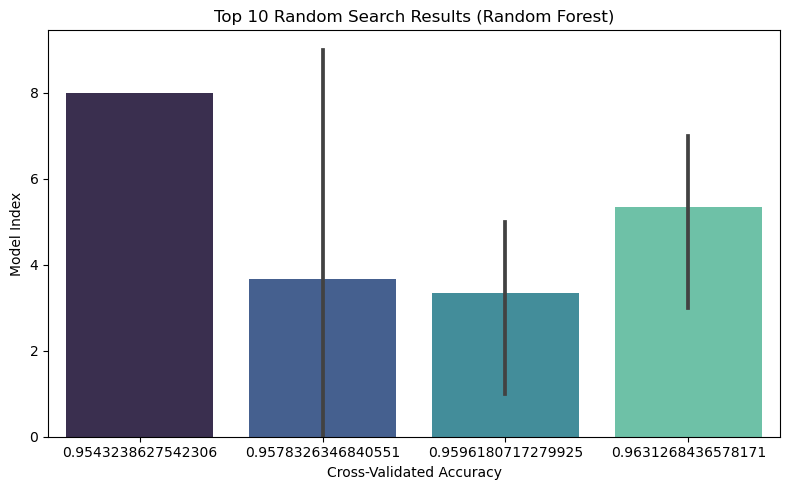

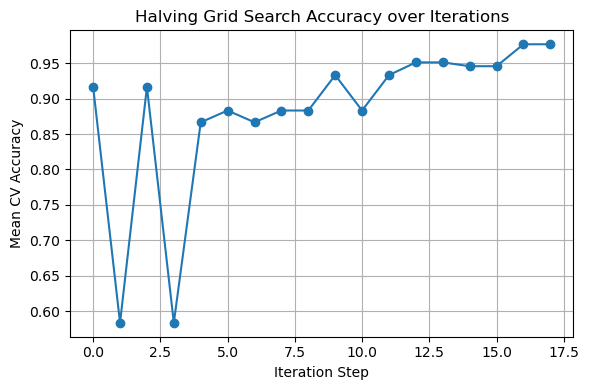

[I 2025-03-22 00:26:26,825] A new study created in memory with name: no-name-719bbac2-56e6-48b4-8a65-fa95a34cc4e4
[I 2025-03-22 00:26:27,002] Trial 0 finished with value: 0.6274181027790716 and parameters: {'C': 0.0017862128354057055, 'gamma': 0.00040387620815795816, 'kernel': 'rbf'}. Best is trial 0 with value: 0.6274181027790716.
[I 2025-03-22 00:26:27,079] Trial 1 finished with value: 0.9736531594472908 and parameters: {'C': 25.19131234227375, 'gamma': 0.002840551040310258, 'kernel': 'rbf'}. Best is trial 1 with value: 0.9736531594472908.
[I 2025-03-22 00:26:27,133] Trial 2 finished with value: 0.968390001552554 and parameters: {'C': 0.01167857604159772, 'gamma': 0.02456858773454717, 'kernel': 'linear'}. Best is trial 1 with value: 0.9736531594472908.
[I 2025-03-22 00:26:27,203] Trial 3 finished with value: 0.9754075454122031 and parameters: {'C': 0.032096998901080906, 'gamma': 0.0008707076307781114, 'kernel': 'linear'}. Best is trial 3 with value: 0.9754075454122031.
[I 2025-03-22 

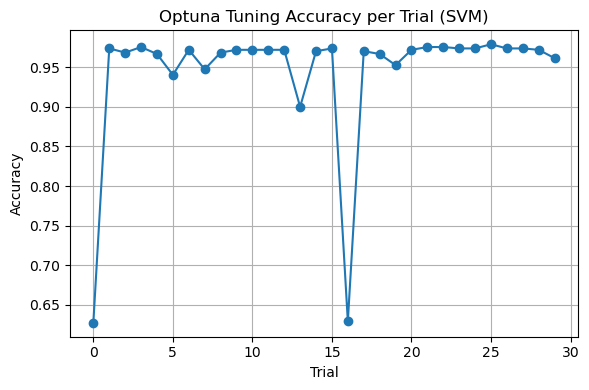

                   Tuning Method  Best Accuracy
0              Grid Search (SVM)       0.977177
1  Random Search (Random Forest)       0.963127
2      Halving Grid Search (SVM)       0.976960
3                   Optuna (SVM)       0.978916


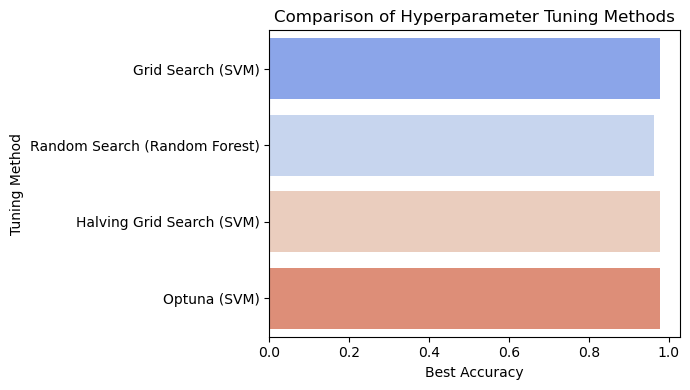

In [5]:
# -------------------------------------
# IMPORTS
# -------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Optional: Optuna
try:
    import optuna
    optuna_available = True
except ImportError:
    optuna_available = False

# -------------------------------------
# LOAD DATA
# -------------------------------------
data = load_breast_cancer()
X, y = data.data, data.target

# Define pipelines
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC())
])

rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])

# -------------------------------------
# 1. GRID SEARCH (SVM)
# -------------------------------------
svm_param_grid = {
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['linear', 'rbf'],
    'clf__gamma': ['scale', 'auto']
}
grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

# Heatmap Visualization (Grid Search)
grid_df = pd.DataFrame(grid_search.cv_results_['params'])
grid_df['mean_test_score'] = grid_search.cv_results_['mean_test_score']
rbf_df = grid_df[grid_df['clf__kernel'] == 'rbf'].pivot(index='clf__C', columns='clf__gamma', values='mean_test_score')
plt.figure(figsize=(6, 4))
sns.heatmap(rbf_df, annot=True, cmap='viridis', fmt=".3f")
plt.title('Grid Search Accuracy (SVM, RBF Kernel)')
plt.xlabel('Gamma')
plt.ylabel('C')
plt.tight_layout()
plt.savefig('grid_search_heatmap.png')
plt.show()

# -------------------------------------
# 2. RANDOM SEARCH (Random Forest)
# -------------------------------------
rf_param_dist = {
    'clf__n_estimators': [50, 100, 150],
    'clf__max_depth': [5, 10, 15, None],
    'clf__min_samples_split': [2, 5, 10]
}
random_search = RandomizedSearchCV(rf_pipeline, rf_param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X, y)

# Bar Plot (Random Search)
random_df = pd.DataFrame(random_search.cv_results_)
top10 = random_df.sort_values('mean_test_score', ascending=False).head(10)
plt.figure(figsize=(8, 5))
sns.barplot(x='mean_test_score', y=top10.index, data=top10, palette='mako')
plt.title('Top 10 Random Search Results (Random Forest)')
plt.xlabel('Cross-Validated Accuracy')
plt.ylabel('Model Index')
plt.tight_layout()
plt.savefig('random_search_barplot.png')
plt.show()

# -------------------------------------
# 3. HALVING GRID SEARCH (SVM)
# -------------------------------------
halving_search = HalvingGridSearchCV(svm_pipeline, svm_param_grid, cv=5, scoring='accuracy')
halving_search.fit(X, y)

# Line Plot (Halving Search)
halving_df = pd.DataFrame(halving_search.cv_results_)
plt.figure(figsize=(6, 4))
plt.plot(halving_df['mean_test_score'], marker='o')
plt.title('Halving Grid Search Accuracy over Iterations')
plt.xlabel('Iteration Step')
plt.ylabel('Mean CV Accuracy')
plt.grid(True)
plt.tight_layout()
plt.savefig('halving_search_lineplot.png')
plt.show()

# -------------------------------------
# 4. OPTUNA (Bayesian Optimization for SVM)
# -------------------------------------
if optuna_available:
    def objective(trial):
        C = trial.suggest_loguniform('C', 1e-3, 1e2)
        gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)
        kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', SVC(C=C, gamma=gamma, kernel=kernel))
        ])
        return cross_val_score(pipeline, X, y, cv=5, scoring='accuracy').mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=30)

    # Plot Optuna Accuracy Over Trials
    optuna_scores = [trial.value for trial in study.trials]
    plt.figure(figsize=(6, 4))
    plt.plot(optuna_scores, marker='o')
    plt.title('Optuna Tuning Accuracy per Trial (SVM)')
    plt.xlabel('Trial')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('optuna_accuracy_plot.png')
    plt.show()

# -------------------------------------
# 5. FINAL COMPARISON
# -------------------------------------
results = {
    "Grid Search (SVM)": grid_search.best_score_,
    "Random Search (Random Forest)": random_search.best_score_,
    "Halving Grid Search (SVM)": halving_search.best_score_
}
if optuna_available:
    results["Optuna (SVM)"] = study.best_value

results_df = pd.DataFrame(list(results.items()), columns=["Tuning Method", "Best Accuracy"])
print(results_df)

# Final Comparison Bar Plot
plt.figure(figsize=(7, 4))
sns.barplot(data=results_df, x='Best Accuracy', y='Tuning Method', palette='coolwarm')
plt.title('Comparison of Hyperparameter Tuning Methods')
plt.tight_layout()
plt.savefig('tuning_comparison.png')
plt.show()
